In [2]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import chi2

import seaborn as sns

df = pd.read_csv('result.csv')

#columns_to_remove=['date','readiness_temperature_trend_deviation']

active=[i for i in df.columns if "Active_" in i]
bowel=[i for i in df.columns if"Bowel Movements_" in i]
creative=[i for i in df.columns if "Creative_" in i]
lifestyle=[i for i in df.columns if "Lifestyle_" in i]
meds=[i for i in df.columns if "Meds/Supplements_" in i]
energy=[i for i in df.columns if "Energy_" in i]
mood=[i for i in df.columns if "Mood_" in i]
nutrition=[i for i in df.columns if "Nutrition_" in i]
sleep=[i for i in df.columns if "Sleep_" in i]
symptom=[i for i in df.columns if "Symptom_" in i]
weather=[i for i in df.columns if "Weather_" in i]
sleep_metrics=['deep_sleep','efficiency_x','latency','rem_sleep','restfulness','timing','total_sleep']  #what is efficiency y?
hrv=['average_breath','average_heart_rate','average_hrv','lowest_heart_rate']
sleep=['Sleep_Blue','Sleep_Drink water before bed','Sleep_Early Bedtime','Sleep_Fan on','Sleep_Individual blanket','Sleep_Late Bedtime','Sleep_Screentime 1h from bedtime','day_of_week','is_weekend']
readiness=[i for i in df.columns if "readiness_" in i]

X=df[sleep_metrics+sleep]
print(X.shape)

(164, 16)


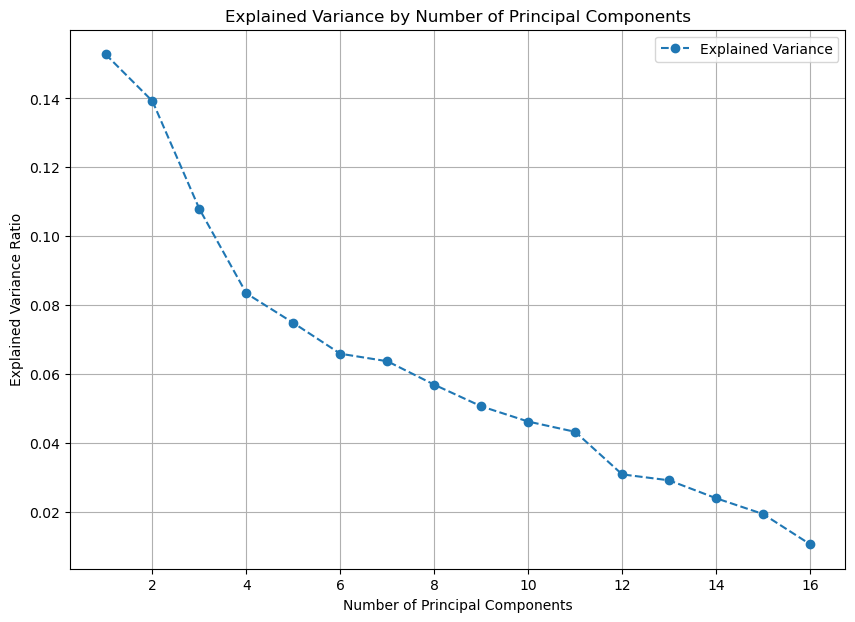

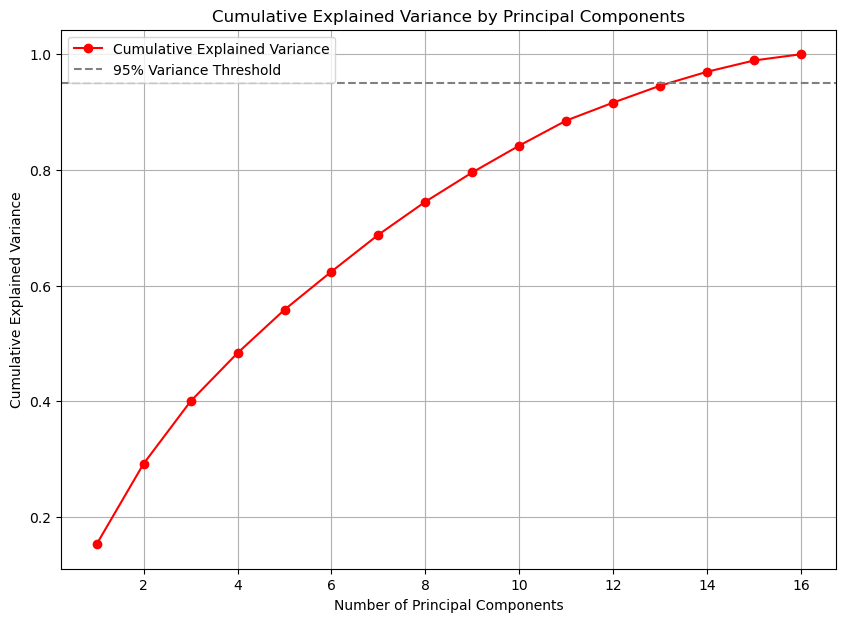

In [3]:
def plot_variance(X):
    # Standardize Data
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    # Fit PCA
    pca = PCA()
    low_d = pca.fit_transform(Xs)

    # Explained Variance Ratio Plot
    plt.figure(figsize=(10, 7))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
             pca.explained_variance_ratio_, marker='o', linestyle='--', label="Explained Variance")
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by Number of Principal Components')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Cumulative Variance Plot
    plt.figure(figsize=(10, 7))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
             np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-', color='r', label="Cumulative Explained Variance")
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance by Principal Components')
    plt.axhline(y=0.95, color='gray', linestyle='--', label='95% Variance Threshold')
    plt.grid(True)
    plt.legend()
    plt.show()

    return pca  # Return the PCA model if needed

# Run the function
pca_model = plot_variance(X)

Explained Variance: [0.15280927 0.13919465 0.10791263 0.08345922 0.07489754 0.06597155
 0.06379722 0.05699596]
Total Variance Explained: 0.74503803130592


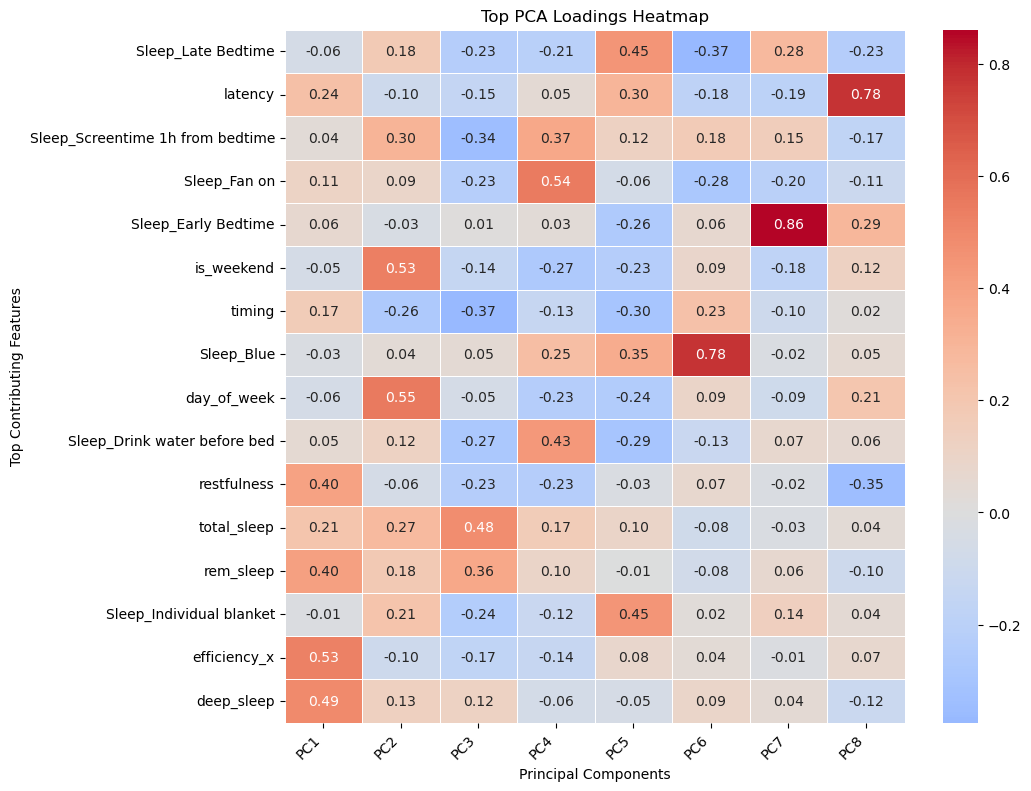

In [4]:
def plot_pca(X, n_components):
    # Fit and transform the data
    scaler= StandardScaler()
    X_s = scaler.fit_transform(X)

    # Initialize PCA with the desired number of components
    pca = PCA(n_components=n_components)
    X_pca=pca.fit_transform(X_s)

    # Add the PCA results back to the dataframe
    pca_columns = [f'PC{i+1}' for i in range(n_components)]
    df_pca = pd.DataFrame(X_pca, columns=pca_columns)

    
    # Function to add confidence ellipses
    def add_ellipses(fig, df, x_col, y_col):
        data_subset = df[[x_col, y_col]].values.T
        cov_matrix = np.cov(data_subset)

        # Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        # Sort in descending order
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]

        # Compute ellipse rotation angle
        angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])

        # Confidence levels
        confidence_levels = [0.90, 0.95, 0.99]
        colors = ['green', 'blue', 'red']
        labels = ['90% Confidence Ellipse', '95% Confidence Ellipse', '99% Confidence Ellipse']
        dash_styles = ['dash', 'dash', 'dashdot']

        mean_x, mean_y = df[x_col].mean(), df[y_col].mean()

        # Plot ellipses
        t = np.linspace(0, 2 * np.pi, 100)
        for i, confidence_level in enumerate(confidence_levels):
            chi2_val = np.sqrt(chi2.ppf(confidence_level, df=2))
            width, height = 2 * chi2_val * np.sqrt(eigenvalues)

            ellipse_x = mean_x + width * np.cos(t) * np.cos(angle) - height * np.sin(t) * np.sin(angle)
            ellipse_y = mean_y + width * np.cos(t) * np.sin(angle) + height * np.sin(t) * np.cos(angle)

            fig.add_trace(go.Scatter(
                x=ellipse_x,
                y=ellipse_y,
                mode='lines',
                name=labels[i],
                line=dict(color=colors[i], width=1, dash=dash_styles[i])
            ))

    # Only plot PC1 vs. PC2
    if n_components >= 2:
        fig = px.scatter(df_pca, x="PC1", y="PC2",
                         title="PCA PC1 vs PC2 with Confidence Ellipses",
                         labels={"PC1": "PC1", "PC2": "PC2"})
        add_ellipses(fig, df_pca, "PC1", "PC2")
        fig.show()
    else:
        print("Not enough principal components to plot (requires at least 2).")

    return pca, pca_columns

# Show loadings
def show_loadings(model, pca_columns, X):
    loadings = model.components_

    if isinstance(X, pd.DataFrame):
        feature_names = X.columns
    else:
        feature_names = [f'Feature_{i}' for i in range(X.shape[1])]

    loading_df = pd.DataFrame(loadings.T, columns=pca_columns, index=feature_names)
    print("Explained Variance:", model.explained_variance_ratio_)
    print("Total Variance Explained:", model.explained_variance_ratio_.sum())

    return loading_df

def plot_pca_loadings(loading_df, top_n=20):
    """
    Plots a heatmap of PCA loadings, displaying only the top N most important features per PC.

    Parameters:
    - loading_df: DataFrame of PCA loadings (features as rows, PCs as columns).
    - top_n: Number of most important features to display.
    """
    # Compute absolute loadings to get top contributing features
    loading_df_abs = loading_df.abs()

    # Select top N features that contribute the most in any PC
    top_features = loading_df_abs.sum(axis=1).nlargest(top_n).index

    # Filter DataFrame to only include top contributing features
    filtered_loadings = loading_df.loc[top_features]

    # Dynamically adjust figure size
    fig_width = 10  # Fixed width
    fig_height = max(6, min(0.3 * top_n, 20))  # Adjust height based on the number of rows

    # Plot heatmap
    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(filtered_loadings, cmap="coolwarm", center=0, annot=True, fmt=".2f",
                linewidths=0.5, cbar=True)

    plt.title("Top PCA Loadings Heatmap")
    plt.xlabel("Principal Components")
    plt.ylabel("Top Contributing Features")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

n_components = 8
model, pca_columns = plot_pca(X, n_components)
loading_df = show_loadings(model, pca_columns, X)

plot_pca_loadings(loading_df, top_n=30)  